In [1]:
# import libraries
import numpy as py

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Python Requests Module
import requests

# Python Math Module
import math

# JSON
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    openssl-1.1.1f             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                       

### Import Excel file with Municipality Data

In [2]:
# The code was removed by Watson Studio for sharing.

,Municipality,Longitude,Median Household Income,Population,Area - sq miles,Population Density - people per sq mi,LAT
0,Atlantis,-80.093,76641,1883,1.44,1309.45,26.5944
1,​Belle Glade,-80.6678,26859,17597,5.71,3079.62,26.6842
2,​Boca Raton,-80.0833,68804,87848,31.29,2807.81,26.3583
3,​Boynton Beach,-80.0666667,53188,70120,16.51,4247.63,26.525
4,Briny Breezes,-80.0509,38274,702,0.11,6324.32,26.5084


In [8]:
# Rename the data frame
df_pbc = df_data_0
df_pbc.head()

,Municipality,Longitude,Median Household Income,Population,Area - sq miles,Population Density - people per sq mi,LAT
0,Atlantis,-80.093,76641,1883,1.44,1309.45,26.5944
1,Belle Glade,-80.6678,26859,17597,5.71,3079.62,26.6842
2,Boca Raton,-80.0833,68804,87848,31.29,2807.81,26.3583
3,Boynton Beach,-80.0666667,53188,70120,16.51,4247.63,26.525
4,Briny Breezes,-80.0509,38274,702,0.11,6324.32,26.5084


In [9]:
# Remove special characters from municipality names 
df_pbc['Municipality'][1] = 'Belle Glade'
df_pbc['Municipality'][2] = 'Boca Raton'
df_pbc['Municipality'][3] = 'Boynton Beach'

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
# Shorten names of columns
df_pbc = df_pbc.rename(columns={'Median Household Income' : 'Income'})
df_pbc = df_pbc.rename(columns={'Area - sq miles' : 'Area'})
df_pbc = df_pbc.rename(columns={'Population Density - people per sq mi' : 'Density'})
df_pbc.head()

,Municipality,Longitude,Income,Population,Area,Density,LAT
0,Atlantis,-80.093,76641,1883,1.44,1309.45,26.5944
1,Belle Glade,-80.6678,26859,17597,5.71,3079.62,26.6842
2,Boca Raton,-80.0833,68804,87848,31.29,2807.81,26.3583
3,Boynton Beach,-80.0666667,53188,70120,16.51,4247.63,26.525
4,Briny Breezes,-80.0509,38274,702,0.11,6324.32,26.5084


In [11]:
# Ensure all values are the appropriate type
df_pbc.Longitude = df_pbc.Longitude.astype(float)
df_pbc.LAT = df_pbc.LAT.astype(float)
df_pbc.Income = df_pbc.Income.astype(int)
df_pbc.Population = df_pbc.Population.astype(int)
df_pbc.Area = df_pbc.Area.astype(float)
df_pbc.Density = df_pbc.Density.astype(float)

### Call Nominatim to get the latitude and longitude of Palm Beach County 
### Display a Folium map of the county

In [12]:
# Call Nominatim to get the latitude and longitude of Palm Beach County
address = 'Palm Beach County, FL'

geolocator = Nominatim(user_agent="pbc_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Palm Beach County, FL are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Palm Beach County, FL are 26.6279798, -80.4494174.


In [63]:
# Create a Folium map of Palm Beach County using latitude and longitude values
map_pbc = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
label = folium.Popup('Palm Beach County', parse_html=True)
folium.CircleMarker(
    [latitude, longitude],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_pbc)  
    
map_pbc

### Display a map of Palm Beach County Municipalities
#### Include popups with Municipality Name, Population, and Median Income

In [64]:
# create map of Palm Beach County and its municipalities using latitude and longitude values
map_pbc = folium.Map(location=[latitude, longitude], zoom_start=10)

for municipality, income, pop, lat, lng in zip(df_pbc['Municipality'],df_pbc['Income'],
df_pbc['Population'],df_pbc['LAT'], df_pbc['Longitude']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup = (municipality + '<br>'
        'Population: '  + str("{:,}".format(pop)) + '<br>'   
        'Median Income: ' + '$' + str("{:,}".format(income))),
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_pbc)
map_pbc

### Plot Histograms of Income, Population, Area, and Population Density in Palm Beach County

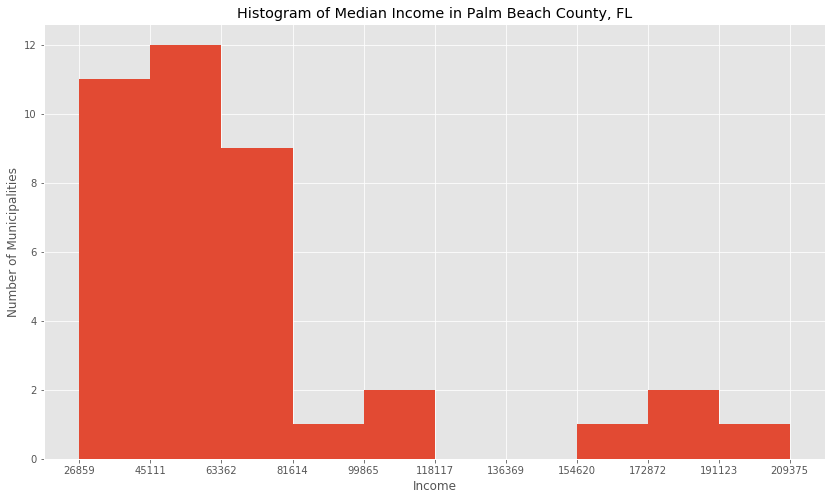

In [32]:
# Histogram of Median Income in Palm Beach County

count,bin_edges = np.histogram(df_pbc['Income']) # 'bin_edges' is a list of bin intervals

df_pbc['Income'].plot(kind='hist', figsize=(14, 8),xticks=bin_edges)

plt.title('Histogram of Median Income in Palm Beach County, FL') # Histogram title
plt.ylabel('Number of Municipalities') # y-label
plt.xlabel('Income') # x-label

plt.show()

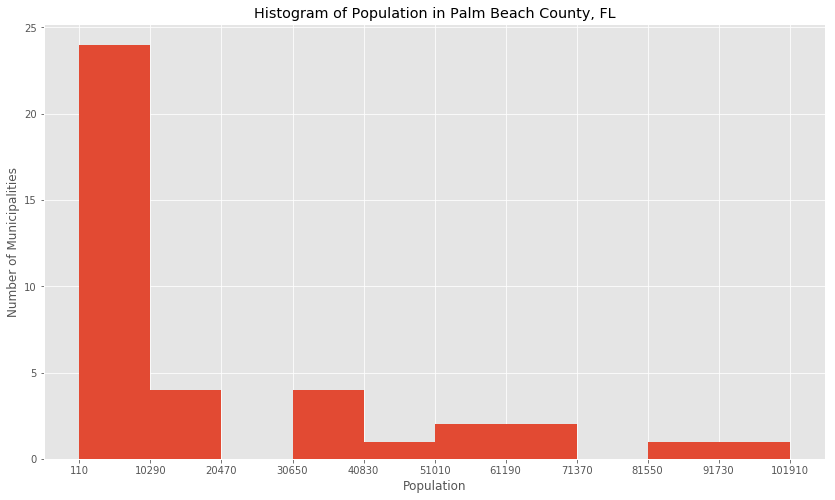

In [33]:
# Histogram of Population in Palm Beach County

count,bin_edges = np.histogram(df_pbc['Population']) # 'bin_edges' is a list of bin intervals

df_pbc['Population'].plot(kind='hist', figsize=(14, 8),xticks=bin_edges)

plt.title('Histogram of Population in Palm Beach County, FL') # Histogram Title
plt.ylabel('Number of Municipalities') # y-label
plt.xlabel('Population') # x-label

plt.show()

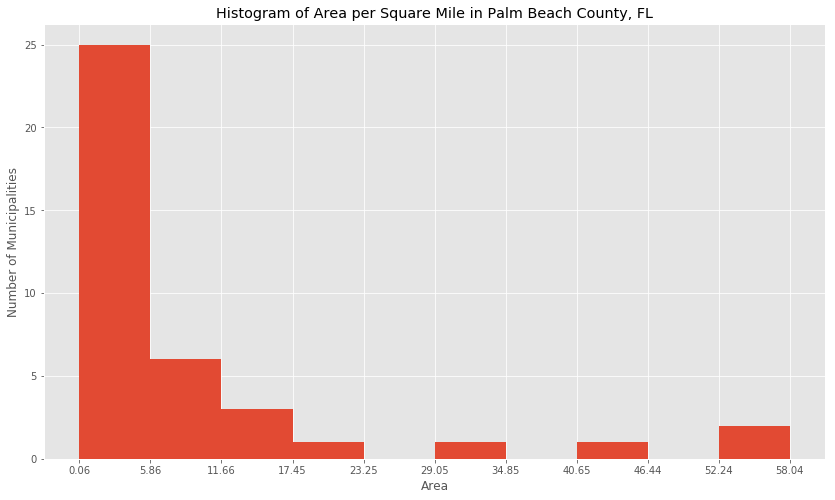

In [27]:
# Histogram of Area in Square Miles in Palm Beach County

count,bin_edges = np.histogram(df_plots['Area']) # 'bin_edges' is a list of bin intervals

df_plots['Area'].plot(kind='hist', figsize=(14, 8),xticks=bin_edges)

plt.title('Histogram of Area per Square Mile in Palm Beach County, FL') # Histogram Title
plt.ylabel('Number of Municipalities') # y-label
plt.xlabel('Area') # x-label

plt.show()

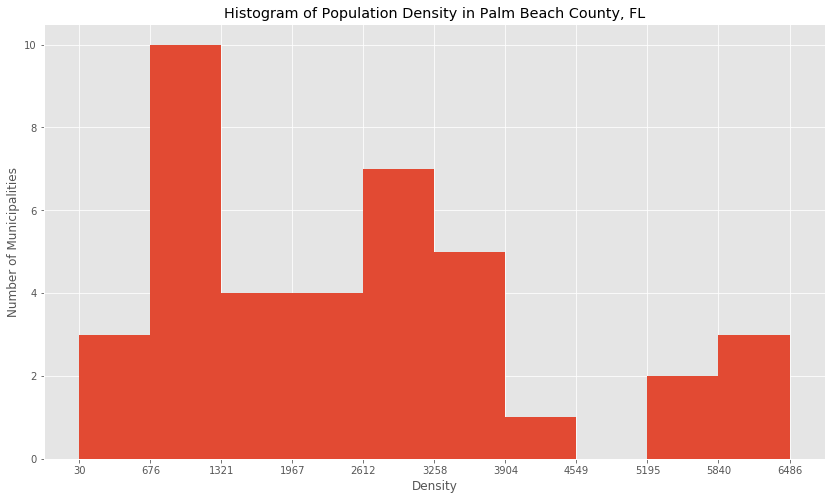

In [45]:
# Histogram of Population Density in Palm Beach County

count,bin_edges = np.histogram(df_pbc['Density']) # 'bin_edges' is a list of bin intervals

df_pbc['Density'].plot(kind='hist', figsize=(14, 8),xticks=bin_edges)

plt.title('Histogram of Population Density in Palm Beach County, FL') # Histogram Title
plt.ylabel('Number of Municipalities') # y-label
plt.xlabel('Density') # x-label

plt.show()

### Plot Bar Charts of Income and Population Density in Palm Beach County

In [59]:
# Create a dataframe with just municipality and income; set Municipality as the index
# Sort by Income descending

df_temp = df_pbc.iloc[:,[0,2]] 
df_temp.set_index('Municipality', inplace=True)
df_bar = df_temp.sort_values(by = 'Income')
df_bar.head()

,Income
Municipality,
Belle Glade,26859
Pahokee,27907
Westlake,28308
South Bay,29405
Mangonia Park,32107


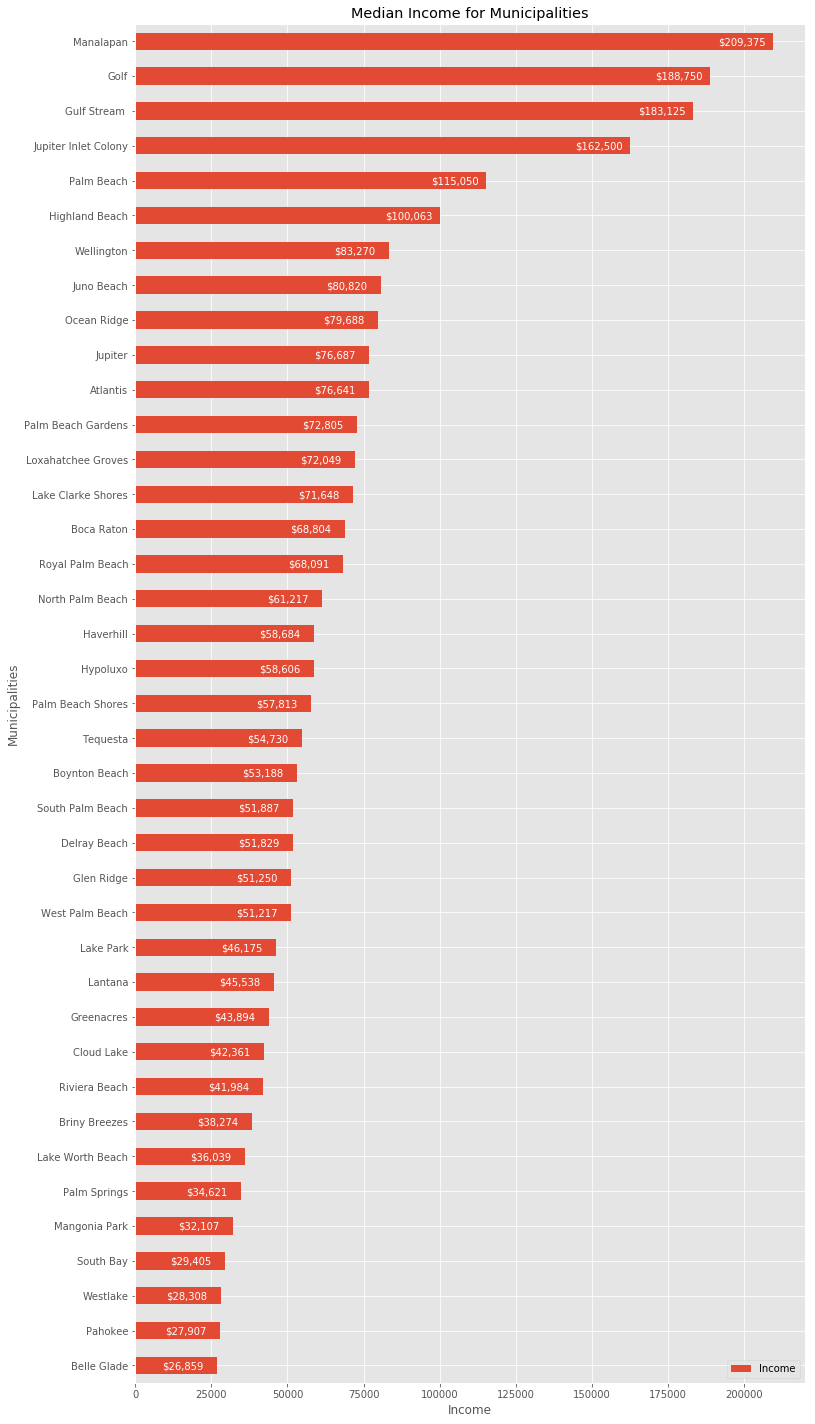

In [65]:
# Create a bar chart of Income for each Municipality

df_bar.plot(kind='barh', figsize=(12, 25))

plt.xlabel('Income') # x-label
plt.ylabel('Municipalities') # y-label
plt.title('Median Income for Municipalities') # Bar Chart title

# annotate value labels to each country
for index, value in enumerate(df_bar.Income): 
    label = '$' + format(int(value), ',') # format income amount with $ and comma
    # place text at the end of bar (subtracting 47000 from x, and 0.1 from y to make it fit within the bar)
    plt.annotate(label, xy=(value - 18000, index - 0.10), color='white')
    
plt.show()

In [15]:
# Create a dataframe with just municipality and population; set Municipality as the index
# Sort by Income descending

df_temp = df_pbc.iloc[:,[0,5]] 
df_temp.set_index('Municipality', inplace=True)
df_bar_p = df_temp.sort_values(by = 'Density')
df_bar_p.head()

,Density
Municipality,
Manalapan,30.14
Loxahatchee Groves,257.03
Golf,345.60
Palm Beach,766.02
Glen Ridge,888.37


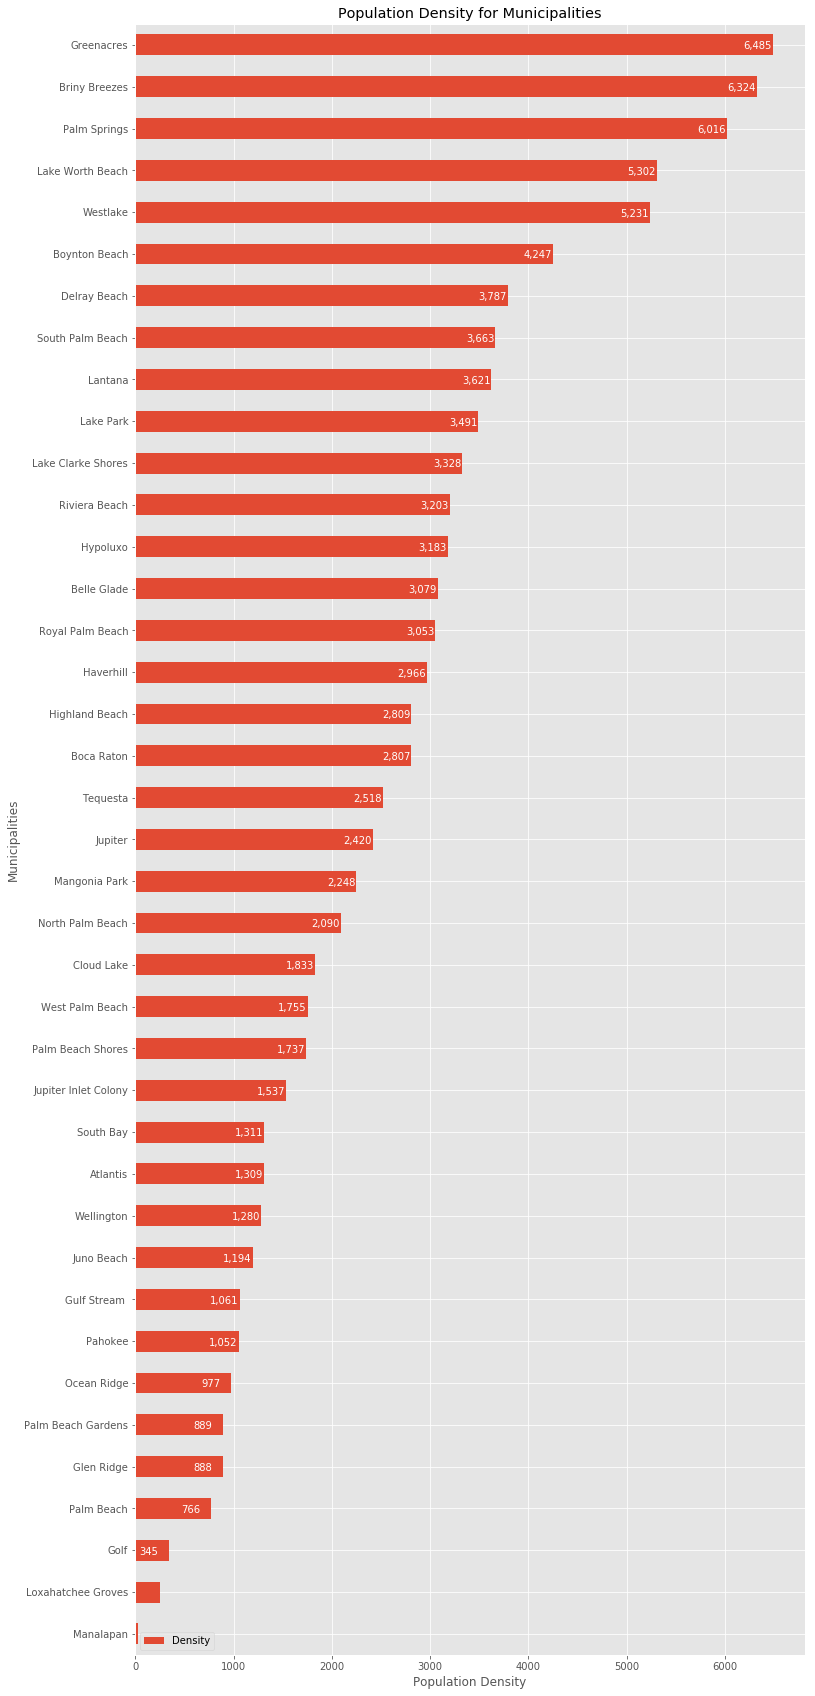

In [72]:
# Create a bar chart of Population for each Municipality

df_bar_p.plot(kind='barh', figsize=(12, 30))

plt.xlabel('Population Density') # x-label
plt.ylabel('Municipalities') # y-label
plt.title('Population Density for Municipalities') # Bar Chart title

# annotate value labels to each country
for index, value in enumerate(df_bar_p.Density): 
    label = format(int(value), ',') # format int with commas
    
    # place text at the end of bar (subtracting 47000 from x, and 0.1 from y to make it fit within the bar)
    #plt.annotate(label, xy=(value - 300, index - 0.10), color='white')
    plt.annotate(label, xy=(value - 300, index - 0.10), color='white')
    
plt.show()

# Foursquare 

### Define credentials and parameters for API call; Set up API call
### Get venues for each municipality
### Determine top ten venues for each municipality in order to perform K Nearest Neighbor analysis

In [15]:
# The code was removed by Watson Studio for sharing.

In [65]:


# Define Parameters - Set limit to the top 100 venues within 1.5 miles for each municipality
limit = 100 # limit of number of venues returned by Foursquare API

# Determine radius based upon average square miles of all municipalities
pbc_average_sq_area = df_pbc['Area'].mean()
pbc_average_area = math.sqrt(pbc_average_sq_area)
pbc_radius = pbc_average_area / 2

# Convert to meters - 1.52 miles = 2447 meters rounded 
radius = round(1609.344 * pbc_radius)

print(radius) 

2447


In [20]:
# All the information is in the items key. 
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [21]:
# Function to get all venues for all municipalities in Palm Beach County
def getNearbyVenues(names, latitudes, longitudes, radius=8047):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Municipality', 
                  'Municipality Latitude', 
                  'Municipality Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
# Call function getNearbyVenues to get venues
pbc_venues = getNearbyVenues(names=df_pbc['Municipality'],
                                   latitudes=df_pbc['LAT'],
                                   longitudes=df_pbc['Longitude']
                                  )
pbc_venues.head()

,Municipality,Municipality Latitude,Municipality Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Atlantis,26.59436,-80.09298,Atlantis Country Club,26.600687,-80.097322,Golf Course
1,Atlantis,26.59436,-80.09298,John Prince Golf Center,26.606548,-80.088790,Golf Course
2,Atlantis,26.59436,-80.09298,Tacos Al Carbon,26.610225,-80.090393,Mexican Restaurant
3,Atlantis,26.59436,-80.09298,Starbucks,26.570610,-80.089243,Coffee Shop
4,Atlantis,26.59436,-80.09298,Wawa,26.618280,-80.088492,Convenience Store


In [23]:
# Check how many venues were returned for each municipality
pbc_venues.groupby('Municipality').count()

,Municipality Latitude,Municipality Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Municipality,,,,,,
Atlantis,100,100,100,100,100,100
Belle Glade,32,32,32,32,32,32
Boca Raton,100,100,100,100,100,100
Boynton Beach,100,100,100,100,100,100
Briny Breezes,100,100,100,100,100,100
Cloud Lake,94,94,94,94,94,94
Delray Beach,100,100,100,100,100,100
Glen Ridge,100,100,100,100,100,100
Golf,100,100,100,100,100,100


In [24]:
# Find how many unique categories can be curated from all the returned venues
print('There are {} unique categories.'.format(len(pbc_venues['Venue Category'].unique())))

There are 212 unique categories.


In [25]:
# Analyze each municipality
 
# Returns DataFrame pcb_onehot with dummy-coded data for Venue Category column only
pbc_onehot = pd.get_dummies(pbc_venues[['Venue Category']], prefix="", prefix_sep="")

# performed onehot coding on municipality - drop the column
#pbc_onehot.drop(['Municipality'], axis=1)

# add municipality column to dataframe
pbc_onehot['Municipality'] = pbc_venues['Municipality']
pbc_onehot.head()

,African Restaurant,Airport,Airport Lounge,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Beach,Beer Bar,Beer Garden,Big Box Store,Bistro,Board Shop,Bookstore,Botanical Garden,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Buffet,Burger Joint,Burrito Place,Café,Campground,Car Wash,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Football Field,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Credit Union,Cuban Restaurant,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Electronics Store,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Fish Market,Flower Shop,Fondue Restaurant,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,High School,History Museum,Hobby Shop,Home Service,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,Hunting Supply,Ice Cream Shop,Indian Restaurant,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Knitting Store,Lake,Latin American Restaurant,Lighthouse,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Optical Shop,Other Great Outdoors,Outlet Mall,Paintball Field,Park,Parking,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Pub,RV Park,Ramen Restaurant,Resort,Rest Area,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Strip Club,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Tapas Restaurant,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo,Zoo Exhibit,Municipality
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Atlantis
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Atlantis
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [26]:
# find the position of the 'Municipality' column
column_position = pbc_onehot.columns.get_loc('Municipality')
print("position: ",column_position )

position:  212


In [27]:
# move municipality column to the first column
# pbc_onehot.columns[position] is the Municipality column
# concatenate the Municipality column with the list of columns before it and after it
fixed_columns = [pbc_onehot.columns[column_position]] + list(pbc_onehot.columns[:column_position]) + list(pbc_onehot.columns[column_position + 1:])


# save the dataframe with the new arrangement of columns
pbc_onehot = pbc_onehot[fixed_columns]
       
pbc_onehot.head()

,Municipality,African Restaurant,Airport,Airport Lounge,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Beach,Beer Bar,Beer Garden,Big Box Store,Bistro,Board Shop,Bookstore,Botanical Garden,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Buffet,Burger Joint,Burrito Place,Café,Campground,Car Wash,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Football Field,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Credit Union,Cuban Restaurant,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Electronics Store,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Fish Market,Flower Shop,Fondue Restaurant,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,High School,History Museum,Hobby Shop,Home Service,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,Hunting Supply,Ice Cream Shop,Indian Restaurant,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Knitting Store,Lake,Latin American Restaurant,Lighthouse,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Optical Shop,Other Great Outdoors,Outlet Mall,Paintball Field,Park,Parking,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Pub,RV Park,Ramen Restaurant,Resort,Rest Area,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Strip Club,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Tapas Restaurant,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo,Zoo Exhibit
0,Atlantis,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Atlantis,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Atlantis,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [28]:
# Get size of dataframe
pbc_onehot.shape

(3725, 213)

In [29]:
# Group rows by municipality and by the frequency of occurrence mean for each category
pbc_grouped = pbc_onehot.groupby('Municipality').mean().reset_index()
pbc_grouped

,Municipality,African Restaurant,Airport,Airport Lounge,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Beach,Beer Bar,Beer Garden,Big Box Store,Bistro,Board Shop,Bookstore,Botanical Garden,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Buffet,Burger Joint,Burrito Place,Café,Campground,Car Wash,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Football Field,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Credit Union,Cuban Restaurant,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Electronics Store,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Fish Market,Flower Shop,Fondue Restaurant,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,High School,History Museum,Hobby Shop,Home Service,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,Hunting Supply,Ice Cream Shop,Indian Restaurant,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Knitting Store,Lake,Latin American Restaurant,Lighthouse,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Optical Shop,Other Great Outdoors,Outlet Mall,Paintball Field,Park,Parking,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Pub,RV Park,Ramen Restaurant,Resort,Rest Area,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Strip Club,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Tapas Restaurant,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo,Zoo Exhibit
0,Atlantis,0.00,0.01000,0.00,0.040000,0.00,0.00,0.00,0.00,0.00,0.00000,0.01000,0.00000,0.00,0.010000,0.00,0.00,0.000000,0.02000,0.00,0.01,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.020000,0.04000,0.00,0.02000,0.000000,0.000000,0.00000,0.00,0.00,0.000000,0.01,0.01,0.00,0.020000,0.00,0.00,0.00,0.040000,0.000000,0.00,0.03,0.00,0.00000,0.01,0.01000,0.000000,0.00,0.00000,0.040000,0.00,0.00000,0.00,0.00000,0.000000,0.01,0.000000,0.01,0.010000,0.01,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.020000,0.00,0.00,0.00,0.00000,0.030000,0.00,0.01,0.090000,0.000000,0.01,0.010000,0.00,0.00,0.010000,0.010000,0.01,0.00,0.000000,0.00,0.00,0.00000,0.000000,0.03,0.00,0.00,0.00,0.010000,0.00,0.00,0.00,0.000000,0.00,0.00,0.00000,0.00,0.00,0.00,0.000000,0.03,0.00,0.00,0.000000,0.00,0.01,0.00,0.00,0.00,0.050000,0.00,0.00,0.00,0.00000,0.000000,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00000,0.020000,0.00,0.01,0.01,0.000000,0.000000,0.00,0.010000,0.000000,0.00,0.000000,0.00,0.00000,0.00,0.000000,0.00,0.010000,0.000000,0.00,0.01,0.010

In [30]:
# Confirm the dataframe size
pbc_grouped.shape

(39, 213)

In [31]:
# print each municipality along with the top 5 most common venues
num_top_venues = 5

for m in pbc_grouped['Municipality']:
    
    # print the subtitle
    print("----"+m+"----")
    
    # if the municipality matches the current municipality, save it in temp, transposed, and reset the index
    temp = pbc_grouped[pbc_grouped['Municipality'] == m].T.reset_index()
    
    # add columns venue and freq to temp
    temp.columns = ['venue','freq']
    
    # assign all venues and frequencies to the appropriate columns
    temp = temp.iloc[1:]
    
    # set frequency to float and round to two decimal places
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    
    # sort venues by their frequencies in descending order
    # print only the first 5 venues
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Atlantis----
                 venue  freq
0        Grocery Store  0.09
1   Mexican Restaurant  0.05
2    Convenience Store  0.04
3  American Restaurant  0.04
4           Donut Shop  0.04


----Belle Glade----
                  venue  freq
0  Fast Food Restaurant  0.12
1              Pharmacy  0.09
2                  Park  0.09
3        Discount Store  0.06
4           Pizza Place  0.06


----Boca Raton----
           venue  freq
0    Coffee Shop  0.06
1  Grocery Store  0.06
2          Beach  0.04
3    Pizza Place  0.04
4          Hotel  0.04


----Boynton Beach----
                 venue  freq
0                Hotel  0.06
1  American Restaurant  0.05
2                Beach  0.05
3               Bakery  0.04
4          Coffee Shop  0.04


----Briny Breezes----
                 venue  freq
0  American Restaurant  0.07
1                Beach  0.06
2   Seafood Restaurant  0.05
3                Hotel  0.04
4          Coffee Shop  0.03


----Cloud Lake----
                  venue  freq
0

In [32]:
# Put the top venues into a dataframe
# First, write a function to sort the venues in descending order.
# given each row in a municipality, sort by most common venue for num_top_venues
def return_most_common_venues(row, num_top_venues):
    
    # select the venue and frequency from the row
    row_categories = row.iloc[1:]
    
    # sort the frequencies in descending order
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    # return only the top venues
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
# Create the new dataframe and display the top 10 venues for each municipality
import numpy as np
num_top_venues = 10

# add 'st', or 'nd', or 'rd' to venue column name - 1st, 2nd, 3rd
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
# First column is Municipality
columns = ['Municipality']

# Add columns for 1st through number of top venues
# NumPy arange() is one of the array creation routines based on numerical ranges. 
# It creates an instance of ndarray with evenly spaced values and returns the reference to it.
for ind in np.arange(num_top_venues):
    try:
        # When ind is 0, column is 1st. When ind is 1, column is 2nd. When ind is 2, column is 3rd.
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        # When ind is 3 to num_top_venues, column is ind+1th.
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe with the columns just named
municipalities_venues_sorted = pd.DataFrame(columns=columns)

# set the new dataframe Municipality column to that in the pbc_grouped dataframe
municipalities_venues_sorted['Municipality'] = pbc_grouped['Municipality']

# for all rows in the pbc_grouped dataframe
# municipalities_venues_sorted where rows match ind, and columns 1 to the end is equal to: 
# call return_most_common_venues function with the row equal to ind, and num_top_venues 
for ind in np.arange(pbc_grouped.shape[0]):
    municipalities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(pbc_grouped.iloc[ind, :], num_top_venues)

# print the new dataframe
municipalities_venues_sorted

,Municipality,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Atlantis,Grocery Store,Mexican Restaurant,Donut Shop,American Restaurant,Convenience Store,Brewery,Seafood Restaurant,Hotel,Golf Course,Latin American Restaurant
1,Belle Glade,Fast Food Restaurant,Pharmacy,Park,Mexican Restaurant,Grocery Store,Discount Store,Sandwich Place,Southern / Soul Food Restaurant,Fried Chicken Joint,Gas Station
2,Boca Raton,Grocery Store,Coffee Shop,Pizza Place,Hotel,American Restaurant,Beach,Mexican Restaurant,Pharmacy,New American Restaurant,Bakery
3,Boynton Beach,Hotel,Beach,American Restaurant,Seafood Restaurant,Bakery,Coffee Shop,Ice Cream Shop,Pizza Place,Pharmacy,Brewery
4,Briny Breezes,American Restaurant,Beach,Seafood Restaurant,Hotel,Coffee Shop,Grocery Store,Italian Restaurant,Brewery,Bakery,New American Restaurant
5,Cloud Lake,Sandwich Place,Grocery Store,Fast Food Restaurant,American Restaurant,Pizza Place,Convenience Store,Discount Store,BBQ Joint,Pharmacy,Coffee Shop
6,Delray Beach,Beach,Grocery Store,New American Restaurant,American Restaurant,Sandwich Place,Coffee Shop,Hotel,Pizza Place,Italian Restaurant,Ice Cream Shop
7,Glen Ridge,Grocery Store,American Restaurant,Italian Restaurant,Hotel,Cuban Restaurant,Convenience Store,Park,Beach,Steakhouse,Coffee Shop
8,Golf,American Restaurant,Pizza Place,Golf Course,Seafood Restaurant,Bakery,Italian Restaurant,New American Restaurant,Deli / Bodega,Hotel,Farmers Market
9,Greenacres,Grocery Store,Golf Course,American Restaurant,Donut Shop,Mexican Restaurant,Park,Latin American Restaurant,Fast Food Restaurant,Convenience Store,Tex-Mex Restaurant


### K Nearest Neighbor 

### Find the best k
#### Run KMeans for all values of k
#### Determine cost and plot

### Given the best k
#### Run KMeans for that k
#### Map the clusters
#### Display 10 best venues for each cluster and determine their defining characteristics

In [34]:
# Find the best k - iterate over 2 to 10 clusters
kMax = 10
cost= [] 

# drop the Municipality column
pbc_grouped_clustering = pbc_grouped.drop('Municipality', 1)

# perform KMeans
for k in range(2,kMax+1):
    kmeans = KMeans(n_clusters = k, random_state=0).fit(pbc_grouped_clustering) 
    # calculates squared error for the clustered points 
    cost.append(kmeans.inertia_)

In [35]:
# Create a dataframe of cost
value_of_k = [2,3,4,5,6,7,8,9,10]

df_cost = pd.DataFrame(cost,value_of_k)
df_cost

,0
2,0.433951
3,0.366730
4,0.321282
5,0.287335
6,0.248397
7,0.220084
8,0.192177
9,0.163049
10,0.146467


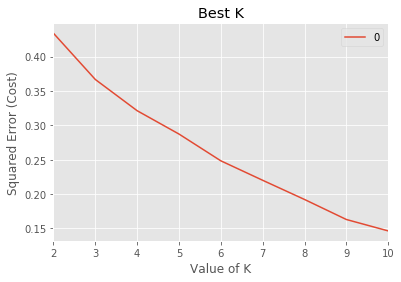

In [36]:
# Plot the cost
df_cost.plot()

plt.title('Best K')
plt.ylabel('Squared Error (Cost)')
plt.xlabel('Value of K')

plt.show()

In [37]:
# Best k is 3
# Cluster Municipalities - Run k-means to cluster the municipalities into 3 clusters.
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(pbc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[:]

array([2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 1, 0, 0, 2, 0, 2], dtype=int32)

In [40]:
# Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
municipalities_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# df_pbc has latitude and longitude
pbc_merged = df_pbc

# combine df_pbc and municipalities_venues_sorted to include venue information and location
pbc_merged = pbc_merged.join(municipalities_venues_sorted.set_index('Municipality'), on='Municipality')

pbc_merged 

,Municipality,Longitude,Income,Population,Area,Density,LAT,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Atlantis,-80.092980,76641,1883,1.44,1309.45,26.594360,2,Grocery Store,Mexican Restaurant,Donut Shop,American Restaurant,Convenience Store,Brewery,Seafood Restaurant,Hotel,Golf Course,Latin American Restaurant
1,Belle Glade,-80.667778,26859,17597,5.71,3079.62,26.684167,2,Fast Food Restaurant,Pharmacy,Park,Mexican Restaurant,Grocery Store,Discount Store,Sandwich Place,Southern / Soul Food Restaurant,Fried Chicken Joint,Gas Station
2,Boca Raton,-80.083333,68804,87848,31.29,2807.81,26.358333,0,Grocery Store,Coffee Shop,Pizza Place,Hotel,American Restaurant,Beach,Mexican Restaurant,Pharmacy,New American Restaurant,Bakery
3,Boynton Beach,-80.066667,53188,70120,16.51,4247.63,26.525000,0,Hotel,Beach,American Restaurant,Seafood Restaurant,Bakery,Coffee Shop,Ice Cream Shop,Pizza Place,Pharmacy,Brewery
4,Briny Breezes,-80.050875,38274,702,0.11,6324.32,26.508405,0,American Restaurant,Beach,Seafood Restaurant,Hotel,Coffee Shop,Grocery Store,Italian Restaurant,Brewery,Bakery,New American Restaurant
5,Cloud Lake,-81.281181,42361,110,0.06,1833.33,28.248901,2,Sandwich Place,Grocery Store,Fast Food Restaurant,American Restaurant,Pizza Place,Convenience Store,Discount Store,BBQ Joint,Pharmacy,Coffee Shop
6,Delray Beach,-80.072800,51829,61553,16.25,3787.64,26.461500,0,Beach,Grocery Store,New American Restaurant,American Restaurant,Sandwich Place,Coffee Shop,Hotel,Pizza Place,Italian Restaurant,Ice Cream Shop
7,Glen Ridge,-80.074209,51250,191,0.22,888.37,26.669511,2,Grocery Store,American Restaurant,Italian Restaurant,Hotel,Cuban Restaurant,Convenience Store,Park,Beach,Steakhouse,Coffee Shop
8,Golf,-80.108654,188750,291,0.84,345.60,26.498683,0,American Restaurant,Pizza Place,Golf Course,Seafood Restaurant,Bakery,Italian Restaurant,New American Restaurant,Deli / Bodega,Hotel,Farmers Market
9,Greenacres,-80.135390,43894,38046,5.87,6485.85,26.627628,2,Grocery Store,Golf Course,American Restaurant,Donut Shop,Mexican Restaurant,Park,Latin American Restaurant,Fast Food Restaurant,Convenience Store,Tex-Mex Restaurant


In [66]:
# Visualize the resulting clusters
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(pbc_merged['LAT'], pbc_merged['Longitude'], pbc_merged['Municipality'], pbc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

In [42]:
# Examine Clusters
# Examine each cluster and determine the discriminating venue categories that distinguish each cluster. 
# Based on the defining categories, assign a name to each cluster.

# Cluster 0 - Tourist oriented with Beaches, Golf, and restaurants (especially Seafood restaurants)   
pbc_merged.loc[pbc_merged['Cluster Labels'] == 0, pbc_merged.columns[[0] + list(range(7, pbc_merged.shape[1]))]]

,Municipality,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Boca Raton,0,Grocery Store,Coffee Shop,Pizza Place,Hotel,American Restaurant,Beach,Mexican Restaurant,Pharmacy,New American Restaurant,Bakery
3,Boynton Beach,0,Hotel,Beach,American Restaurant,Seafood Restaurant,Bakery,Coffee Shop,Ice Cream Shop,Pizza Place,Pharmacy,Brewery
4,Briny Breezes,0,American Restaurant,Beach,Seafood Restaurant,Hotel,Coffee Shop,Grocery Store,Italian Restaurant,Brewery,Bakery,New American Restaurant
6,Delray Beach,0,Beach,Grocery Store,New American Restaurant,American Restaurant,Sandwich Place,Coffee Shop,Hotel,Pizza Place,Italian Restaurant,Ice Cream Shop
8,Golf,0,American Restaurant,Pizza Place,Golf Course,Seafood Restaurant,Bakery,Italian Restaurant,New American Restaurant,Deli / Bodega,Hotel,Farmers Market
10,Gulf Stream,0,Beach,American Restaurant,Seafood Restaurant,Grocery Store,Coffee Shop,Hotel,Italian Restaurant,Fast Food Restaurant,Bakery,New American Restaurant
12,Highland Beach,0,Beach,Grocery Store,Coffee Shop,American Restaurant,Bagel Shop,Hotel,Italian Restaurant,Mexican Restaurant,Bakery,Asian Restaurant
13,Hypoluxo,0,Grocery Store,Hotel,American Restaurant,Seafood Restaurant,Beach,Donut Shop,Brewery,Coffee Shop,Mexican Restaurant,Bar
14,Juno Beach,0,Beach,American Restaurant,Seafood Restaurant,Grocery Store,Pizza Place,Resort,Breakfast Spot,Italian Restaurant,Coffee Shop,Ice Cream Shop
15,Jupiter,0,Beach,Grocery Store,Seafood Restaurant,Italian Restaurant,Golf Course,American Restaurant,Thai Restaurant,Coffee Shop,Burger Joint,Bagel Shop


In [43]:
# Cluster 1 - Rural country living 
pbc_merged.loc[pbc_merged['Cluster Labels'] == 1, pbc_merged.columns[[0] + list(range(7, pbc_merged.shape[1]))]]

,Municipality,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,South Bay,1,River,Farm,Burrito Place,Gun Range,Harbor / Marina,Sports Bar,Donut Shop,Festival,Fruit & Vegetable Store,Frozen Yogurt Shop


In [44]:
# Cluster 2 - Suburban residential area with parks, golf, and plenty of places to eat out
pbc_merged.loc[pbc_merged['Cluster Labels'] == 2, pbc_merged.columns[[0] + list(range(7, pbc_merged.shape[1]))]]

,Municipality,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Atlantis,2,Grocery Store,Mexican Restaurant,Donut Shop,American Restaurant,Convenience Store,Brewery,Seafood Restaurant,Hotel,Golf Course,Latin American Restaurant
1,Belle Glade,2,Fast Food Restaurant,Pharmacy,Park,Mexican Restaurant,Grocery Store,Discount Store,Sandwich Place,Southern / Soul Food Restaurant,Fried Chicken Joint,Gas Station
5,Cloud Lake,2,Sandwich Place,Grocery Store,Fast Food Restaurant,American Restaurant,Pizza Place,Convenience Store,Discount Store,BBQ Joint,Pharmacy,Coffee Shop
7,Glen Ridge,2,Grocery Store,American Restaurant,Italian Restaurant,Hotel,Cuban Restaurant,Convenience Store,Park,Beach,Steakhouse,Coffee Shop
9,Greenacres,2,Grocery Store,Golf Course,American Restaurant,Donut Shop,Mexican Restaurant,Park,Latin American Restaurant,Fast Food Restaurant,Convenience Store,Tex-Mex Restaurant
11,Haverhill,2,Grocery Store,Sandwich Place,American Restaurant,Park,Cuban Restaurant,Coffee Shop,Latin American Restaurant,Fast Food Restaurant,Indian Restaurant,Art Museum
17,Lake Clarke Shores,2,American Restaurant,Grocery Store,Seafood Restaurant,Mexican Restaurant,Cuban Restaurant,Latin American Restaurant,Convenience Store,Park,Bar,Coffee Shop
19,Lake Worth Beach,2,Grocery Store,Donut Shop,Mexican Restaurant,American Restaurant,Convenience Store,Ice Cream Shop,Seafood Restaurant,Bar,Cuban Restaurant,Thai Restaurant
21,Loxahatchee Groves,2,Grocery Store,American Restaurant,Coffee Shop,Pizza Place,Pharmacy,Park,Mexican Restaurant,Golf Course,Donut Shop,Ice Cream Shop
28,Pahokee,2,Grocery Store,American Restaurant,Donut Shop,Pizza Place,Seafood Restaurant,Golf Course,Mexican Restaurant,Coffee Shop,Fast Food Restaurant,Sushi Restaurant
